# Setup

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## Configuration

In [2]:
# Set parameters
WINDOW_SIZE = 120 # in hours
PREDICTION_STEP = 1    # in hours
BATCH_SIZE = 64
HIDDEN_SIZE = 32
NUM_LAYERS = 2
LEARNING_RATE = 0.0001
N_EPOCHS = 50
SPLIT_FRACTION = 0.8   # Train/test split ratio

# Set seeds for reproducibility
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set device for computation
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Data

In [3]:
def load_and_preprocess_data(file_path):
    """Load, preprocess and resample data to hourly frequency"""
    print("Loading and resampling data...")
    df_full = pd.read_csv(file_path)

    # Convert timestamp to datetime
    df_full['timestamp'] = pd.to_datetime(df_full['Timestamp'], unit='s')
    df_full = df_full.set_index('timestamp')

    print(f"Full dataset date range: {df_full.index.min()} to {df_full.index.max()}")

    # Resample to hourly frequency
    df_hourly = df_full.loc['2018-01-01':]['Close'].resample('h').last().dropna().to_frame()

    print(f"Resampled to {len(df_hourly)} hourly data points.")
    print(df_hourly.describe())

    return df_hourly

In [4]:
def create_features(df):
    """Create financial features for the model"""
    # Calculate hourly log returns
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Calculate Moving Averages on 'Close' price
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Close'].rolling(window=10).mean()

    # Calculate Volatility (rolling standard deviation of log returns)
    df['Volatility_10'] = df['log_return'].rolling(window=10).std()
    df['Volatility_20'] = df['log_return'].rolling(window=20).std()

    # Calculate distance from moving averages
    df['dist_from_SMA5'] = (df['Close'] - df['SMA_5']) / df['SMA_5']
    df['dist_from_SMA10'] = (df['Close'] - df['SMA_10']) / df['SMA_10']

    # Drop NaN values and reset index
    df = df.dropna().reset_index()

    print(f"Calculated features. Shape: {df.shape}")
    return df

In [5]:
def prepare_data(df_hourly, split_fraction=SPLIT_FRACTION):
    """Split and normalize data"""
    # Split data into train and test sets
    split_idx = int(len(df_hourly) * split_fraction)
    train_data = df_hourly.iloc[:split_idx].copy()
    test_data = df_hourly.iloc[split_idx:].copy()

    print(f"Training data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    print(f"Test set date range: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")

    # Define features to scale
    feature_names = ['log_return', 'dist_from_SMA5', 'dist_from_SMA10',
                     'Volatility_10', 'Volatility_20']
    scaled_feature_names = [f'scaled_{col}' for col in feature_names]

    # Normalize features
    scaler = StandardScaler()
    scaler.fit(train_data[feature_names])  # Fit only on training data

    # Apply scaler to both train and test data
    train_data[scaled_feature_names] = scaler.transform(train_data[feature_names])
    test_data[scaled_feature_names] = scaler.transform(test_data[feature_names])

    return train_data, test_data, scaled_feature_names

In [6]:
def create_lagged_data(data, window_size, prediction_step, feature_cols, target_col='log_return', device=None):
    """
    Create lagged data for predicting a specific future step with multiple features.

    Args:
        data: DataFrame with features and target
        window_size: Number of past hours for input features
        prediction_step: How many hours ahead to predict
        feature_cols: List of column names for input features
        target_col: Column name for target variable
        device: Device to place tensors on

    Returns:
        x, y: PyTorch tensors of inputs (scaled) and targets (unscaled)
    """
    x, y = [], []

    for i in range(len(data) - window_size - prediction_step + 1):
        # Input features: past window_size hours of scaled features
        feature_slice = data[feature_cols].iloc[i:i + window_size].values

        # Target: sum of actual returns for the next prediction_step hours
        target_indices = range(i + window_size, i + window_size + prediction_step)
        target = data[target_col].iloc[target_indices].sum()

        x.append(feature_slice)
        y.append(target)

    x = np.array(x)  # Shape: (num_samples, window_size, num_features)
    y = np.array(y)  # Shape: (num_samples,)

    x_tensor = torch.FloatTensor(x).to(device)
    y_tensor = torch.FloatTensor(y).to(device)

    return x_tensor, y_tensor

# Model

In [7]:
class RNN_model(torch.nn.Module):
    """LSTM-based RNN model for time series prediction"""
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.rnn = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.1  # Dropout between layers if num_layers > 1
        )
        self.fc1 = torch.nn.Linear(hidden_size, 30)
        self.fc2 = torch.nn.Linear(30, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)

        # Get the output from the last time step
        out = out[:, -1, :]  # Shape: (batch, hidden_size)

        out = torch.nn.functional.relu(self.fc1(out))
        out = self.fc2(out)
        return out.squeeze(-1)  # Shape: (batch)

class SharpeLoss(torch.nn.Module):
    """Loss function that maximizes Sharpe ratio of strategy returns"""
    def __init__(self, threshold=0):
        super(SharpeLoss, self).__init__()
        self.threshold = threshold

    def forward(self, pred_returns, actual_returns):
        # Use a continuous approximation of the step function
        positive_signals = torch.sigmoid(10 * (pred_returns - self.threshold))
        negative_signals = -torch.sigmoid(10 * (-pred_returns - self.threshold))
        signals = positive_signals + negative_signals

        # Calculate strategy returns
        strategy_returns = signals * actual_returns

        # Calculate Sharpe ratio components
        mean_return = torch.mean(strategy_returns)
        std_return = torch.std(strategy_returns) + 1e-6  # Avoid division by zero

        return -mean_return / std_return  # Negative because we want to maximize

In [8]:
def train_RNN(model, n_epochs, loader, optimizer, loss_fn, x_train, x_test, y_train, y_test, device):
    """Train the RNN model and periodically evaluate performance"""
    train_losses = []
    test_rmses = []
    eval_batch_size = 128

    print("Starting Training...")
    for epoch in range(n_epochs):
        model.train()
        batch_losses = []

        for x_batch, y_batch in loader:
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

        epoch_loss = np.mean(batch_losses)
        train_losses.append(epoch_loss)

        # Validation every 5 epochs or on the final epoch
        if epoch % 5 == 0 or epoch == n_epochs - 1:
            model.eval()
            with torch.no_grad():
                # Evaluate on Training Set
                train_preds_list = []
                current_pos = 0

                while current_pos < len(x_train):
                    x_batch_eval = x_train[current_pos:min(current_pos + eval_batch_size, len(x_train))]
                    if x_batch_eval.shape[0] > 0:  # Ensure batch not empty
                        batch_preds = model(x_batch_eval)
                        train_preds_list.append(batch_preds)
                    current_pos += eval_batch_size

                if not train_preds_list:  # Handle case where train set is smaller than eval_batch_size
                    train_rmse = float('nan')
                else:
                    y_pred_train = torch.cat(train_preds_list)
                    train_rmse = torch.sqrt(torch.mean((y_pred_train - y_train) ** 2))

                # Evaluate on Test Set
                test_preds_list = []
                current_pos = 0

                while current_pos < len(x_test):
                    x_batch_eval = x_test[current_pos:min(current_pos + eval_batch_size, len(x_test))]
                    if x_batch_eval.shape[0] > 0:  # Ensure batch not empty
                        batch_preds = model(x_batch_eval)
                        test_preds_list.append(batch_preds)
                    current_pos += eval_batch_size

                if not test_preds_list:  # Handle case where test set is smaller than eval_batch_size
                    test_rmse = float('nan')
                    test_rmses.append(test_rmse)
                else:
                    y_pred_test = torch.cat(test_preds_list)
                    test_rmse = torch.sqrt(torch.mean((y_pred_test - y_test) ** 2))
                    test_rmses.append(test_rmse.item())

            print(f"Epoch {epoch}: Train Loss {epoch_loss:.6f}, Train RMSE {train_rmse:.6f}, Test RMSE {test_rmse:.6f}")

    print("Training Finished.")
    return train_losses, test_rmses

In [9]:
def evaluate_model(model, x_test, y_test, batch_size, device):
    """Evaluate model performance on test data"""
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    all_predictions = []

    with torch.no_grad():
        for x_batch, _ in test_loader:
            y_pred_batch = model(x_batch).cpu()
            all_predictions.append(y_pred_batch)

        y_pred_test = torch.cat(all_predictions, dim=0).numpy()

    y_actual_test = y_test.cpu().numpy()

    # Calculate performance metrics
    mse = mean_squared_error(y_actual_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_actual_test, y_pred_test)
    mae = np.mean(np.abs(y_actual_test - y_pred_test))

    print(f"Test Set Performance Metrics:")
    print(f"MSE: {mse:.8f}")
    print(f"RMSE: {rmse:.8f}")
    print(f"MAE: {mae:.8f}")
    print(f"R²: {r2:.6f}")

    return y_pred_test, y_actual_test

# Strategy

In [93]:
def generate_trading_signals(predictions, threshold=0):
    """Generate trading signals based on predictions"""
    signals = np.zeros(len(predictions))
    signals[predictions > threshold] = 1     # Long position
    signals[predictions < -threshold] = -1   # Short position
    return signals

def calculate_strategy_performance(signals, actual_returns, test_dates=None):
    """
    Calculate performance metrics for trading strategy including win rate and max drawdown.
    Optionally includes the period of max drawdown if test_dates are provided.
    """
    # Calculate strategy returns
    strategy_returns = signals * actual_returns

    # Calculate cumulative returns
    cumulative_strategy_returns = np.cumsum(strategy_returns)
    cumulative_benchmark_returns = np.cumsum(actual_returns)

    # Calculate Sharpe ratio (annualized for hourly data)
    if np.std(strategy_returns) > 1e-9:
        # Annualization factor for hourly trading (approx 24*252 = 6048 trading hours per year)
        trading_hours_per_year = 24 * 252
        sharpe_ratio = (np.mean(strategy_returns) / np.std(strategy_returns)) * np.sqrt(trading_hours_per_year)
    else:
        sharpe_ratio = 0.0
        print("Warning: Standard deviation of strategy returns is zero or near-zero.")

    # Calculate Win Rate, Average Gain, Average Loss (based on completed trades)
    trade_outcomes = []
    current_position = 0  # 0: hold, 1: long, -1: short
    trade_start_idx = -1

    for i in range(len(signals)):
        if signals[i] != current_position:  # Signal change detected
            # End previous trade if active
            if current_position != 0:
                # Calculate return for the previous trade (applying current_position to actual_returns)
                trade_return = np.sum(actual_returns[trade_start_idx:i] * current_position)
                trade_outcomes.append(trade_return)

            # Start new trade if new signal is not 0
            if signals[i] != 0:
                current_position = signals[i]
                trade_start_idx = i
            else:  # Signal switches to 0 (hold)
                current_position = 0
                trade_start_idx = -1  # No active trade

    # Handle the last open trade if it extends to the end of the data
    if current_position != 0:
        trade_return = np.sum(actual_returns[trade_start_idx:len(signals)] * current_position)
        trade_outcomes.append(trade_return)

    if len(trade_outcomes) > 0:
        winning_trades_count = sum(1 for outcome in trade_outcomes if outcome > 0)
        win_rate = (winning_trades_count / len(trade_outcomes)) * 100

        # Calculate average gain and average loss (in log returns initially)
        winning_trades_values = [outcome for outcome in trade_outcomes if outcome > 0]
        losing_trades_values = [outcome for outcome in trade_outcomes if outcome < 0]

        avg_gain_per_trade_log = np.mean(winning_trades_values) if len(winning_trades_values) > 0 else 0.0
        # avg_loss_per_trade_log is stored as a positive magnitude for display, actual is negative
        avg_loss_per_trade_log = abs(np.mean(losing_trades_values)) if len(losing_trades_values) > 0 else 0.0
    else:
        win_rate = 0.0
        avg_gain_per_trade_log = 0.0
        avg_loss_per_trade_log = 0.0

    # Calculate Max Drawdown (in log returns) and its period
    max_drawdown_start_date = "N/A"
    max_drawdown_end_date = "N/A"

    if len(cumulative_strategy_returns) > 0:
        peak_values = np.maximum.accumulate(cumulative_strategy_returns)
        drawdown_values = (cumulative_strategy_returns - peak_values)
        max_drawdown_log = np.min(drawdown_values)

        # Find the index of the max drawdown trough
        max_drawdown_trough_idx = np.argmin(drawdown_values)

        # Find the index of the peak that preceded this trough
        # This peak is the highest point up to the trough index
        max_drawdown_peak_idx = np.argmax(peak_values[:max_drawdown_trough_idx + 1])

        # Retrieve the dates if available
        if test_dates is not None and len(test_dates) == len(cumulative_strategy_returns):
            max_drawdown_start_date = test_dates.iloc[max_drawdown_peak_idx].strftime('%Y-%m-%d %H:%M')
            max_drawdown_end_date = test_dates.iloc[max_drawdown_trough_idx].strftime('%Y-%m-%d %H:%M')
    else:
        max_drawdown_log = 0.0


    # Convert relevant metrics from log returns to percentages for printing
    avg_gain_per_trade_perc = (np.exp(avg_gain_per_trade_log) - 1) * 100
    # abs() is used for display as "loss" is usually shown as a positive number
    avg_loss_per_trade_perc = abs((np.exp(-avg_loss_per_trade_log) - 1) * 100)
    max_drawdown_perc = (np.exp(max_drawdown_log) - 1) * 100 # Will remain negative for drawdown

    print(f"Strategy Sharpe Ratio (Annualized): {sharpe_ratio:.4f}")
    print(f"Strategy Win Rate (per trade): {win_rate:.2f}% (Total trades: {len(trade_outcomes)})")
    print(f"Average Gain per Winning Trade: {avg_gain_per_trade_perc:.4f}%")
    print(f"Average Loss per Losing Trade: {avg_loss_per_trade_perc:.4f}%")
    print(f"Strategy Max Drawdown: {max_drawdown_perc:.4f}%")
    print(f"Max Drawdown Period: {max_drawdown_start_date} to {max_drawdown_end_date}") # New line
    print(f"Signal distribution: Long: {np.sum(signals == 1)}, Short: {np.sum(signals == -1)}, Hold: {np.sum(signals == 0)}")


    return cumulative_strategy_returns, cumulative_benchmark_returns, sharpe_ratio, win_rate, avg_gain_per_trade_perc, avg_loss_per_trade_perc, max_drawdown_log

## Visualization

In [11]:
def plot_returns(cumulative_strategy_returns, cumulative_benchmark_returns, test_dates=None):
    """Plot cumulative returns of strategy vs benchmark"""
    plt.figure(figsize=(14, 7))

    if test_dates is not None and len(test_dates) == len(cumulative_strategy_returns):
        plt.plot(test_dates, cumulative_strategy_returns, label=f'RNN Strategy', color='cyan')
        plt.plot(test_dates, cumulative_benchmark_returns, label='Buy & Hold (Benchmark)', color='orange')
        plt.xlabel('Date')
    else:
        # Fallback to plotting against index if dates don't align
        plt.plot(cumulative_strategy_returns, label=f'RNN Strategy', color='cyan')
        plt.plot(cumulative_benchmark_returns, label='Buy & Hold (Benchmark)', color='orange')
        plt.xlabel('Trading Hours (Test Set)')

    plt.legend()
    plt.title(f'Cumulative Returns: RNN Strategy vs Buy & Hold')
    plt.ylabel('Cumulative Log Returns')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_training_loss(train_losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(y_actual, y_pred):
    """Plot predicted vs actual returns"""
    plt.figure(figsize=(14, 7))
    plt.plot(y_actual, label='Actual Returns', color='blue', alpha=0.7)
    plt.plot(y_pred * 0.1, label='Predicted Returns (scaled for visibility)', color='red', alpha=0.7)
    plt.xlabel('Test Sample Index')
    plt.ylabel('Log Return')
    plt.title('Predicted vs Actual Returns on Test Set')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot prediction error
    plt.figure(figsize=(14, 7))
    prediction_error = y_actual - y_pred
    plt.plot(prediction_error, color='green', alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xlabel('Test Sample Index')
    plt.ylabel('Error (Actual - Predicted)')
    plt.title('Prediction Error on Test Set')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Execution

In [12]:
# Load and preprocess data
df_hourly = load_and_preprocess_data('../data/btcusd_1-min_data.csv')

# Create features
df_hourly = create_features(df_hourly)

# Prepare data (split and normalize)
train_data, test_data, scaled_feature_names = prepare_data(df_hourly)

# Create lagged datasets
x_train, y_train = create_lagged_data(
    train_data, WINDOW_SIZE, PREDICTION_STEP,
    feature_cols=scaled_feature_names,
    target_col='log_return',
    device=device
)
x_test, y_test = create_lagged_data(
    test_data, WINDOW_SIZE, PREDICTION_STEP,
    feature_cols=scaled_feature_names,
    target_col='log_return',
    device=device
)

print(f"Training input shape: {x_train.shape}, target shape: {y_train.shape}")
print(f"Test input shape: {x_test.shape}, target shape: {y_test.shape}")

# Check if datasets are empty
if x_train.shape[0] == 0 or x_test.shape[0] == 0:
    raise ValueError("Created datasets are empty. Check data length and window/prediction steps.")

Loading and resampling data...
Full dataset date range: 2012-01-01 10:01:00 to 2025-05-04 00:50:00
Resampled to 64303 hourly data points.
               Close
count   64303.000000
mean    30955.151467
std     25440.784599
min      3139.760000
25%      9166.460000
50%     23695.480000
75%     46532.995000
max    108276.000000
Calculated features. Shape: (64283, 9)
Training data shape: (51426, 9)
Test data shape: (12857, 9)
Test set date range: 2023-11-14 14:00:00 to 2025-05-04 00:00:00
Training input shape: torch.Size([51306, 120, 5]), target shape: torch.Size([51306])
Test input shape: torch.Size([12737, 120, 5]), target shape: torch.Size([12737])


In [ ]:
# Create data loader for training
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)

# Set model training parameters
input_size = len(scaled_feature_names)

# Create and train model (with SharpeLoss)
model = RNN_model(input_size, HIDDEN_SIZE, NUM_LAYERS).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
loss_fn = SharpeLoss()

# Train the model
train_losses, test_rmses = train_RNN(
    model, N_EPOCHS, train_loader, optimizer, loss_fn,
    x_train, x_test, y_train, y_test, device
)

In [14]:
# Load existing model
model = torch.load('./lstm1h_2.8.pth', weights_only = False, map_location=torch.device('cpu'))

In [ ]:
y_pred_test, y_actual_test = evaluate_model(model, x_test, y_test, BATCH_SIZE, device)

Strategy Sharpe Ratio (Annualized): 2.8008
Strategy Win Rate (per trade): 52.71% (Total trades: 2178)
Average Gain per Winning Trade: 0.9684%
Average Loss per Losing Trade: 0.8225%
Strategy Max Drawdown: -34.2036%
Max Drawdown Period: 2024-07-05 03:00 to 2024-08-06 04:00
Signal distribution: Long: 6201, Short: 6536, Hold: 0


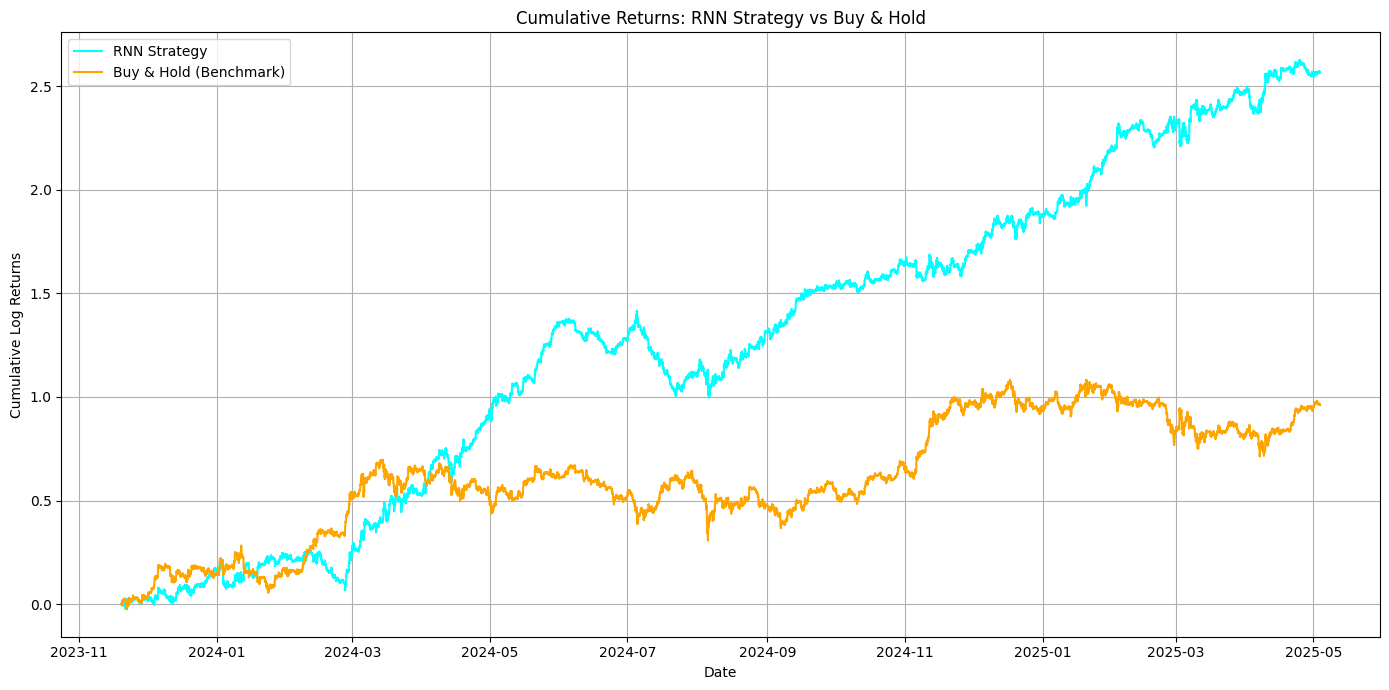

In [99]:
# Evaluate model
# Generate trading signals and evaluate strategy
signals = generate_trading_signals(y_pred_test, threshold=0.0)

cumulative_strategy_returns, cumulative_benchmark_returns, sharpe_ratio, win_rate, avg_gain_per_trade_perc, avg_loss_per_trade_perc, max_drawdown = calculate_strategy_performance(
    signals, y_actual_test, test_dates
)

# Get test dates for plotting
test_dates = test_data.iloc[WINDOW_SIZE + PREDICTION_STEP - 1:
                           WINDOW_SIZE + PREDICTION_STEP - 1 + len(cumulative_strategy_returns)]['timestamp']

# Visualize results
plot_returns(cumulative_strategy_returns, cumulative_benchmark_returns, test_dates)
# plot_training_loss(train_losses)
# plot_predictions_vs_actual(y_actual_test, y_pred_test)

# Save model
# torch.save(model, 'bitcoin_prediction_model.pth')
# print("Model saved successfully.")

Starting threshold optimization for maximum expected return per trade...
Strategy Sharpe Ratio (Annualized): 2.8008
Strategy Win Rate (per trade): 52.71% (Total trades: 2178)
Average Gain per Winning Trade: 0.9684%
Average Loss per Losing Trade: 0.8225%
Strategy Max Drawdown: -34.2036%
Max Drawdown Period: 2024-07-05 03:00 to 2024-08-06 04:00
Signal distribution: Long: 6201, Short: 6536, Hold: 0
Strategy Sharpe Ratio (Annualized): 2.8027
Strategy Win Rate (per trade): 52.93% (Total trades: 2186)
Average Gain per Winning Trade: 0.9532%
Average Loss per Losing Trade: 0.8164%
Strategy Max Drawdown: -34.4708%
Max Drawdown Period: 2024-07-05 03:00 to 2024-08-06 04:00
Signal distribution: Long: 6131, Short: 6475, Hold: 131
Strategy Sharpe Ratio (Annualized): 2.8297
Strategy Win Rate (per trade): 52.98% (Total trades: 2199)
Average Gain per Winning Trade: 0.9522%
Average Loss per Losing Trade: 0.8169%
Strategy Max Drawdown: -32.6153%
Max Drawdown Period: 2024-07-05 03:00 to 2024-08-06 04:00
S

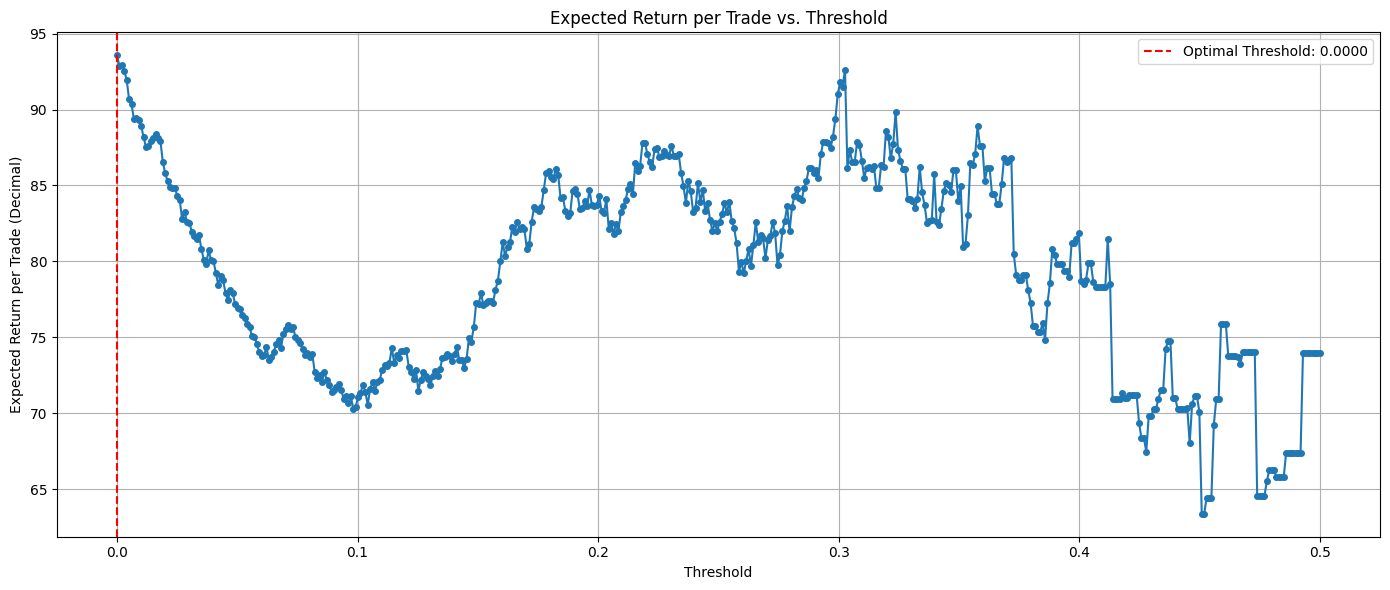

In [95]:
threshold_range = np.linspace(0.00, 0.5, 500)

best_expected_return = -np.inf
optimal_threshold = None
results = []

print("Starting threshold optimization for maximum expected return per trade...")

for threshold_val in threshold_range:
    # Generate signals using the current threshold
    signals_tuned = generate_trading_signals(y_pred_test, threshold=threshold_val)

    # Calculate performance metrics using the modified calculate_strategy_performance function.
    # We are interested in win_rate_p, avg_gain_perc_p, avg_loss_perc_p, and total_trades_p
    # The other returned values are ignored with '_' as they are not needed for this optimization.
    _, _, _, win_rate, avg_gain_per_trade_perc, avg_loss_per_trade_perc, _ = calculate_strategy_performance(signals_tuned, y_actual_test, test_dates)

    expected_return_per_trade = win_rate * avg_gain_per_trade_perc - (1-win_rate) * avg_loss_per_trade_perc

    results.append({'threshold': threshold_val, 'expected_return': expected_return_per_trade})

    if expected_return_per_trade > best_expected_return:
        best_expected_return = expected_return_per_trade
        optimal_threshold = threshold_val

print("\n--- Optimization Complete ---")
print(f"Optimal Threshold for Maximum Expected Return per Trade: {optimal_threshold:.4f}")
print(f"Maximum Expected Return per Trade: {best_expected_return:.6f}")

# Optional: Plotting the optimization results for better understanding
thresholds_plot = [r['threshold'] for r in results]
expected_returns_plot = [r['expected_return'] for r in results]

plt.figure(figsize=(14, 6))

plt.plot(thresholds_plot, expected_returns_plot, marker='o', linestyle='-', markersize=4)
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.title('Expected Return per Trade vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Expected Return per Trade (Decimal)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
